In [1]:
from google.colab import drive

In [2]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# The objective of this project is to build a Convolutional Neural Network model that would classify the plant seedlings into their respective 12 categories. It is expected that the model/classifier will correctly identify the plant's species from the images provided. The model is expected to build 12 probabilities where the highest probability will be used for the each classification.



### Import the necessary libraries will be used for image classification

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras

# Keras Sequential Model
from  tensorflow.keras.models import  Sequential

#import layers and optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam

#import LabelEncoder to help convert the categorical labels to numeric
from sklearn.preprocessing import LabelEncoder

#import utility function for one-hot encoding of the target variables
from keras.utils.np_utils import to_categorical
#import the function to split the data
from sklearn.model_selection import train_test_split

#import random for for seed setting
import random

# library to clear model's history
from tensorflow.keras import backend

#library to stop the model when theres no imptovement in accuracy
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
#load the images and their labels

l_path = "/content/drive/MyDrive/Ailead_CNN_Assignment/Labels.csv"
im_path = "/content/drive/MyDrive/Ailead_CNN_Assignment/images.npy"
images = np.load(im_path)
labels = pd.read_csv(l_path)

In [5]:
images.shape #check the shape of the images

(4750, 128, 128, 3)

In [6]:
type(images)

numpy.ndarray

In [7]:
images[5]

array([[[ 32,  34,  48],
        [ 28,  28,  43],
        [ 29,  32,  50],
        ...,
        [ 38,  49,  66],
        [ 40,  53,  68],
        [ 37,  50,  65]],

       [[ 23,  23,  37],
        [ 27,  26,  38],
        [ 24,  33,  48],
        ...,
        [ 36,  50,  65],
        [ 39,  54,  67],
        [ 35,  49,  63]],

       [[ 25,  24,  37],
        [ 24,  23,  36],
        [ 17,  28,  46],
        ...,
        [ 35,  49,  65],
        [ 35,  50,  64],
        [ 33,  48,  64]],

       ...,

       [[ 57,  80, 100],
        [ 56,  79, 101],
        [ 53,  77, 100],
        ...,
        [ 55,  76,  92],
        [ 55,  78,  96],
        [ 59,  81, 100]],

       [[ 54,  77,  97],
        [ 59,  81, 103],
        [ 52,  76,  99],
        ...,
        [ 58,  80,  95],
        [ 59,  83,  99],
        [ 61,  84, 103]],

       [[ 58,  81, 102],
        [ 59,  81, 102],
        [ 62,  85, 106],
        ...,
        [ 56,  79,  93],
        [ 55,  80,  97],
        [ 56,  80, 100]]

The data is 4 dimensional.
It contains 4750 images with an image dimension 128 x 128 ( ie 128 pixels along the row and height of the images respectively) and uses the RGB color dimension channels (which is the number channels within the images; red, green and blue). The data is also stored as an np array data type and will need to be normalized.

In [8]:
labels.shape #check the shape of the labels

(4750, 1)

In [9]:
#just a random view of the labels
labels

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill
...,...
4745,Loose Silky-bent
4746,Loose Silky-bent
4747,Loose Silky-bent
4748,Loose Silky-bent


In [10]:
type(labels)

pandas.core.frame.DataFrame

In [11]:
#check for the unique labels/classes
labels.Label.unique()

array(['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent'], dtype=object)

In [12]:
# check for the number of labels or classes in the data
labels.Label.nunique()

12

In [13]:
labels.Label.isna().sum() # there are no empty row

0

In [14]:
  # we view the labels to check for class imbalance

labels.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
dtype: int64

The data has 12 classes and has some data balance which will be addressed later

<function matplotlib.pyplot.show(*args, **kw)>

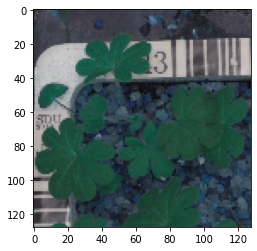

In [15]:
# we randomly view the 4th image
plt.imshow(images[3])
plt.show

In [16]:
labels.iloc[3] # check the label for the above image

Label    Small-flowered Cranesbill
Name: 3, dtype: object

In [17]:
num_classes = 12

#create a list of the categorical names for the classes in alphabetical order
plant_classes = ['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent']
#plant_classes = sorted(plant_classes)
#plant_classes

In [18]:
# rows = 3
# cols = 4
# fig = plt.figure(figsize=(10,8))
# for i in range (cols):
#   for j in range (rows):
#     random_index = np.random.randint(0, len(labels))
#     ax = fig.add_subplot(rows,cols, i * rows + j + 1)
#     ax.imshow(images[random_index, :])
#     ax.set_title(plant_classes[labels.Label[random_index,]])
# plt.show()

# Data Preparation 
## 1. Data will be converted to float
## 2. This will be followed by normalization to also reduce the size of the data. This will help reduce the training time and avoid exploding error gradient
## 3. We encode the representation of the target labels which are text to integer using label encoder then convert the vector of integers to a onehot encoding using to_categorical()
## The data is going to be split up into train and test data

In [19]:
#convert np.array images to float and normalized by dividing by 255 as pixel values range between 0 and 255
images_float = images.astype("float32")/255.0

In [20]:
images_float

array([[[[0.13725491, 0.20392157, 0.30588236],
         [0.14117648, 0.19215687, 0.29803923],
         [0.12156863, 0.1764706 , 0.27058825],
         ...,
         [0.30588236, 0.37254903, 0.44705883],
         [0.29803923, 0.3647059 , 0.43137255],
         [0.3137255 , 0.37254903, 0.42745098]],

        [[0.12941177, 0.18039216, 0.26666668],
         [0.14509805, 0.19607843, 0.28627452],
         [0.1882353 , 0.25490198, 0.3254902 ],
         ...,
         [0.31764707, 0.3764706 , 0.44313726],
         [0.2901961 , 0.34901962, 0.4117647 ],
         [0.3254902 , 0.37254903, 0.42745098]],

        [[0.13333334, 0.19607843, 0.26666668],
         [0.13725491, 0.20392157, 0.28235295],
         [0.27450982, 0.33333334, 0.39607844],
         ...,
         [0.3254902 , 0.38039216, 0.4392157 ],
         [0.30980393, 0.36862746, 0.42352942],
         [0.30980393, 0.36862746, 0.41960785]],

        ...,

        [[0.13725491, 0.19607843, 0.27058825],
         [0.16470589, 0.22352941, 0.28627452]

In [21]:
#initialise the label encoder 
le = LabelEncoder()


In [22]:
# apply and transform the labels to integers
label_le = le.fit_transform(labels.Label)

In [23]:
# convert the vector of integers to a one-hot encoding
Y_cat = to_categorical(label_le)

In [24]:
type(label_le)

numpy.ndarray

In [25]:
type(Y_cat)

numpy.ndarray

In [26]:
# next we shuffle and split the data
train_images,test_images, train_labels,test_labels = train_test_split(images_float,Y_cat, shuffle=True, test_size = 0.2, random_state= 0)

In [27]:
train_images.shape

(3800, 128, 128, 3)

In [28]:
test_images.shape

(950, 128, 128, 3)

In [29]:
train_labels.shape

(3800, 12)

In [30]:
test_labels.shape

(950, 12)

# Model Building

## Model 1
#####. 1 We first set the seed for reproducibility. We set the same seed in numpy, python and Tensor flow

In [31]:
np.random.seed(42) #numpy
random.seed(42) #python
tf.random.set_seed(42) #tensorflow

In [32]:
# initialise model
model = Sequential()

#for the first convolutional layer, we use a filter size of 64 with a kernel size of 3x3 and same padding to make the image resolution input same as output 
model.add(Conv2D(64,(3,3),padding = 'valid', activation= 'relu', input_shape =(128,128,3))) # this gives the feature map

#add max_pooling to reduce the size of the output of the convolution layer. This where the kernel is applied to the feature map
model.add(MaxPool2D())

# add batch normalization to help with vanishing gradient problem
model.add(BatchNormalization())

# add another convolutional layer
model.add(Conv2D(32, (3,3),padding = "same", activation = "relu"))
model.add(MaxPool2D())
model.add(BatchNormalization())

# add another convolutional layer
model.add(Conv2D(32, (3,3),padding = "same", activation = "relu"))
model.add(MaxPool2D())
model.add(BatchNormalization())

#flatten the output of the Convolution Layer to prepare for the Dense layer
model.add(Flatten())

# add a fully connected dense layer with 100 neurons
model.add(Dense(100, activation = "relu"))

# we add the final output layer 
model.add(Dense(12,activation = 'softmax'))

In [33]:
#compile the model using categorical_crossentropy as the loss function which is suitable for multi-class classification problems
model.compile(optimizer = "adam", loss ="categorical_crossentropy", metrics ="accuracy") 

In [34]:
# run the model summary to view the model parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                        

In [35]:
# from above, the model has a total of 751,328 paramenters both weights and biases

In [36]:
# we then train the model
history = model.fit(train_images, train_labels, batch_size = 5, epochs = 30, validation_split= 0.2)

Epoch 1/30
608/608 [==============================] - 9s 10ms/step - loss: 2.0444 - accuracy: 0.4326 - val_loss: 3.1553 - val_accuracy: 0.2724
Epoch 2/30
608/608 [==============================] - 5s 8ms/step - loss: 0.9967 - accuracy: 0.6773 - val_loss: 4.4500 - val_accuracy: 0.2434
Epoch 3/30
608/608 [==============================] - 6s 10ms/step - loss: 0.5645 - accuracy: 0.8122 - val_loss: 1.9393 - val_accuracy: 0.5553
Epoch 4/30
608/608 [==============================] - 4s 7ms/step - loss: 0.3560 - accuracy: 0.8809 - val_loss: 10.8287 - val_accuracy: 0.2474
Epoch 5/30
608/608 [==============================] - 4s 6ms/step - loss: 0.2122 - accuracy: 0.9263 - val_loss: 1.4014 - val_accuracy: 0.6566
Epoch 6/30
608/608 [==============================] - 4s 6ms/step - loss: 0.1875 - accuracy: 0.9411 - val_loss: 1.4646 - val_accuracy: 0.6316
Epoch 7/30
608/608 [==============================] - 4s 6ms/step - loss: 0.2309 - accuracy: 0.9289 - val_loss: 1.4392 - val_accuracy: 0.6908
Epo

In [98]:
score_test = model.evaluate(test_images, test_labels)
score_train = model.evaluate(train_images, train_labels)

119/119 [==============================] - 1s 8ms/step - loss: 0.9638 - accuracy: 0.9008


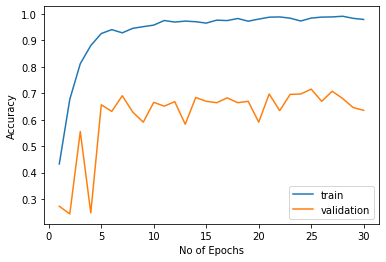

In [37]:
#the model above is overfitting with an accuracy of 99% and test accuracy of 64%
# so we visualise the data
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs = range(1,len(acc)+1)
plt.plot(epochs, acc,label= "train")
plt.plot(epochs, val_acc,label= "validation")
plt.legend()
plt.xlabel("No of Epochs")
plt.ylabel("Accuracy")
plt.show()

## Model 2

In [38]:
#clear the previous model's history to remove it from the backend and prevent the accumulation of weights 
# we also set the seed again

backend.clear_session()

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


In [39]:
# we would be a more complex layer and add some drop outs in the fully connected dense layer to reduce overfitting


# initialise model
model2 = Sequential()

#for the first convolutional layer, we use a filter size of *128* with a kernel size of 3x3 and same padding to make the image resolution input same as output 
model2.add(Conv2D(128,(3,3),padding = 'valid', activation= 'relu', input_shape =(128,128,3))) # this gives the feature map

#add max_pooling to reduce the size of the output of the convolution layer. This where the kernel is applied to the feature map
model2.add(MaxPool2D())

# add batch normalization to help with vanishing gradient problem
model2.add(BatchNormalization())

# add another convolutional layer
model2.add(Conv2D(64, (3,3),padding = "same", activation = "relu"))
model2.add(MaxPool2D())
model2.add(BatchNormalization())

# add another convolutional layer
model2.add(Conv2D(128, (3,3),padding = "same", activation = "relu"))
model2.add(MaxPool2D())
model2.add(BatchNormalization())

#flatten the output of the Convolution Layer to prepare for the Dense layer
model2.add(Flatten())

# add a fully connected dense layer with 100 neurons
model2.add(Dense(500, activation = "relu"))
model2.add(Dropout(0.5))

model2.add(Dense(200, activation = "relu"))
model2.add(Dropout(0.25))
# we add the final output layer 
model2.add(Dense(12,activation = 'softmax'))

In [40]:
#compile the model using categorical_crossentropy as the loss function which is suitable for multi-class classification problems
model2.compile(optimizer = "adam", loss ="categorical_crossentropy", metrics ="accuracy") 

In [41]:
# run the model summary to view the model parameters
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                        

In [42]:
# we then train the model
history = model2.fit(train_images, train_labels, batch_size = 128, epochs = 60, validation_split= 0.2)

Epoch 1/60
24/24 [==============================] - 12s 395ms/step - loss: 3.6270 - accuracy: 0.3148 - val_loss: 2.8609 - val_accuracy: 0.0382
Epoch 2/60
24/24 [==============================] - 5s 191ms/step - loss: 2.1859 - accuracy: 0.4875 - val_loss: 3.6227 - val_accuracy: 0.0487
Epoch 3/60
24/24 [==============================] - 5s 192ms/step - loss: 1.5348 - accuracy: 0.5678 - val_loss: 4.1994 - val_accuracy: 0.0408
Epoch 4/60
24/24 [==============================] - 5s 192ms/step - loss: 1.2079 - accuracy: 0.6326 - val_loss: 6.8072 - val_accuracy: 0.1145
Epoch 5/60
24/24 [==============================] - 5s 191ms/step - loss: 1.0382 - accuracy: 0.6895 - val_loss: 6.5112 - val_accuracy: 0.0382
Epoch 6/60
24/24 [==============================] - 5s 192ms/step - loss: 0.7147 - accuracy: 0.7615 - val_loss: 6.7124 - val_accuracy: 0.1211
Epoch 7/60
24/24 [==============================] - 5s 192ms/step - loss: 0.6158 - accuracy: 0.7964 - val_loss: 8.0205 - val_accuracy: 0.1474
Epoch

In [96]:
score2_test = model2.evaluate(test_images, test_labels)
score2_train = model2.evaluate(train_images, train_labels)

119/119 [==============================] - 2s 16ms/step - loss: 0.3586 - accuracy: 0.9503


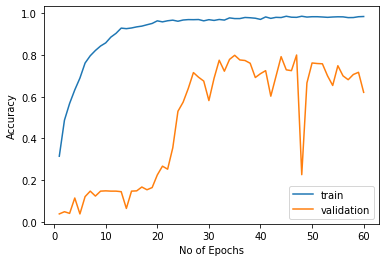

In [43]:
#the model above is overfitting with an accuracy of 99% and test accuracy of 64%
# so we visualise the data
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs = range(1,len(acc)+1)
plt.plot(epochs, acc,label= "train")
plt.plot(epochs, val_acc,label= "validation")
plt.legend()
plt.xlabel("No of Epochs")
plt.ylabel("Accuracy")
plt.show()

## MOdel 3

In [64]:
#clear the previous model's history to remove it from the backend and prevent the accumulation of weights 
# we also set the seed again

backend.clear_session()

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [65]:
# initialise model
model3 = Sequential()

#for the first convolutional layer, we use a filter size of 64 with a kernel size of 3x3 and same padding to make the image resolution input same as output 
model3.add(Conv2D(64,(3,3),padding = 'valid', activation= 'relu', input_shape =(128,128,3))) # this gives the feature map

#add max_pooling to reduce the size of the output of the convolution layer. This where the kernel is applied to the feature map
model3.add(MaxPool2D())

# add batch normalization to help with vanishing gradient problem
model3.add(BatchNormalization())

# add another convolutional layer
model3.add(Conv2D(32, (3,3),padding = "same", activation = "relu"))
model3.add(MaxPool2D())
model3.add(BatchNormalization())

# add another convolutional layer
model3.add(Conv2D(32, (3,3),padding = "same", activation = "relu"))
model3.add(MaxPool2D())
model3.add(BatchNormalization())

#flatten the output of the Convolution Layer to prepare for the Dense layer
model3.add(Flatten())

# add a fully connected dense layer with 100 neurons
model3.add(Dense(100, activation = "relu"))
model3.add(Dropout(0.2))
# we add the final output layer 
model3.add(Dense(12,activation = 'softmax'))

In [66]:
#compile the model using categorical_crossentropy as the loss function which is suitable for multi-class classification problems
model3.compile(optimizer = "adam", loss ="categorical_crossentropy", metrics ="accuracy") 

In [67]:
# run the model summary to view the model parameters
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                        

In [68]:
# we then train the model
history3= model3.fit(train_images, train_labels, batch_size = 64, epochs = 30, validation_split= 0.2)

Epoch 1/30
48/48 [==============================] - 3s 53ms/step - loss: 1.9726 - accuracy: 0.4181 - val_loss: 3.1498 - val_accuracy: 0.0395
Epoch 2/30
48/48 [==============================] - 2s 47ms/step - loss: 0.7754 - accuracy: 0.7516 - val_loss: 4.4983 - val_accuracy: 0.1368
Epoch 3/30
48/48 [==============================] - 2s 47ms/step - loss: 0.3599 - accuracy: 0.8799 - val_loss: 6.7885 - val_accuracy: 0.0421
Epoch 4/30
48/48 [==============================] - 2s 47ms/step - loss: 0.2065 - accuracy: 0.9322 - val_loss: 7.4953 - val_accuracy: 0.0737
Epoch 5/30
48/48 [==============================] - 2s 47ms/step - loss: 0.1277 - accuracy: 0.9602 - val_loss: 5.9150 - val_accuracy: 0.1487
Epoch 6/30
48/48 [==============================] - 3s 53ms/step - loss: 0.0848 - accuracy: 0.9730 - val_loss: 6.8936 - val_accuracy: 0.1566
Epoch 7/30
48/48 [==============================] - 2s 47ms/step - loss: 0.0506 - accuracy: 0.9868 - val_loss: 6.1321 - val_accuracy: 0.1289
Epoch 8/30
48

In [97]:
score3 = model3.evaluate(test_images, test_labels)
score3_train = model3.evaluate(train_images, train_labels)

119/119 [==============================] - 2s 10ms/step - loss: 3.1141 - accuracy: 0.6571


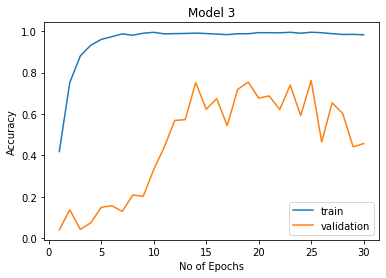

In [70]:
#the model above is overfitting with an accuracy of 99% and test accuracy of 64%
# so we visualise the data
acc = history3.history["accuracy"]
val_acc = history3.history["val_accuracy"]

epochs = range(1,len(acc)+1)
plt.plot(epochs, acc,label= "train")
plt.plot(epochs, val_acc,label= "validation")
plt.legend()
plt.xlabel("No of Epochs")
plt.ylabel("Accuracy")
plt.title("Model 3")
plt.show()

## Model 4

In [88]:
#clear the previous model's history to remove it from the backend and prevent the accumulation of weights 
# we also set the seed again

backend.clear_session()

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [89]:
# initialise model
model4 = Sequential()
model4.add(Dense(16, input_shape = (128,128,3), activation = 'relu'))

#for the first convolutional layer, we use a filter size of *128* with a kernel size of 3x3 and same padding to make the image resolution input same as output 
model4.add(Conv2D(32,(3,3),padding = 'valid', activation= 'relu')) # this gives the feature map

#add max_pooling to reduce the size of the output of the convolution layer. This where the kernel is applied to the feature map
model4.add(MaxPool2D())

# add batch normalization to help with vanishing gradient problem
model4.add(BatchNormalization())

# add another convolutional layer
model4.add(Conv2D(64, (3,3),padding = "same", activation = "relu"))
model4.add(MaxPool2D())
model4.add(BatchNormalization())

# add another convolutional layer
# model4.add(Conv2D(128, (3,3),padding = "same", activation = "relu"))
# model4.add(MaxPool2D())
# model4.add(BatchNormalization())

#flatten the output of the Convolution Layer to prepare for the Dense layer
model4.add(Flatten())

# add a fully connected dense layer with 100 neurons
model4.add(Dense(500, activation = "relu"))
model4.add(Dropout(0.5))

model4.add(Dense(200, activation = "relu"))
model4.add(Dropout(0.25))
# we add the final output layer 
model4.add(Dense(12,activation = 'softmax'))

In [90]:
#compile the model using categorical_crossentropy as the loss function which is suitable for multi-class classification problems
model4.compile(Adam(learning_rate=0.0001), loss = "categorical_crossentropy", metrics ="accuracy") 

In [91]:
# run the model summary to view the model parameters
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128, 128, 16)      64        
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0

In [92]:
es = EarlyStopping(monitor = 'val_loss', patience = 5)

In [93]:
# we then train the model
history4= model4.fit(train_images, train_labels, batch_size = 64, epochs = 30, validation_split= 0.3)

Epoch 1/30
42/42 [==============================] - 4s 72ms/step - loss: 3.1456 - accuracy: 0.2827 - val_loss: 2.4852 - val_accuracy: 0.1395
Epoch 2/30
42/42 [==============================] - 3s 63ms/step - loss: 1.6463 - accuracy: 0.5568 - val_loss: 2.9540 - val_accuracy: 0.1395
Epoch 3/30
42/42 [==============================] - 3s 60ms/step - loss: 1.1625 - accuracy: 0.6583 - val_loss: 3.7060 - val_accuracy: 0.1395
Epoch 4/30
42/42 [==============================] - 3s 61ms/step - loss: 0.8378 - accuracy: 0.7414 - val_loss: 4.4945 - val_accuracy: 0.1395
Epoch 5/30
42/42 [==============================] - 3s 60ms/step - loss: 0.6396 - accuracy: 0.8004 - val_loss: 4.9547 - val_accuracy: 0.1395
Epoch 6/30
42/42 [==============================] - 3s 60ms/step - loss: 0.4495 - accuracy: 0.8474 - val_loss: 4.9810 - val_accuracy: 0.1807
Epoch 7/30
42/42 [==============================] - 3s 61ms/step - loss: 0.3630 - accuracy: 0.8898 - val_loss: 7.4103 - val_accuracy: 0.1395
Epoch 8/30
42

In [94]:
score4_test = model4.evaluate(test_images, test_labels)
score4_train = model4.evaluate(train_images, train_labels)

119/119 [==============================] - 1s 10ms/step - loss: 0.4405 - accuracy: 0.9018


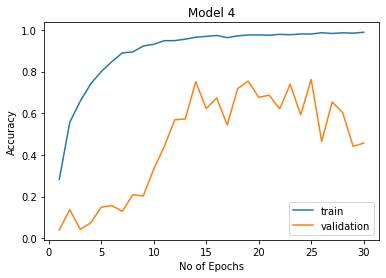

In [95]:
#the model above is overfitting with an accuracy of 99% and test accuracy of 64%
# so we visualise the data
acc = history4.history["accuracy"]
val_acc = history3.history["val_accuracy"]

epochs = range(1,len(acc)+1)
plt.plot(epochs, acc,label= "train")
plt.plot(epochs, val_acc,label= "validation")
plt.legend()
plt.xlabel("No of Epochs")
plt.ylabel("Accuracy")
plt.title("Model 4")
plt.show()